Titanic Survival Prediction

Object：use the Titanic passenger data (name, age, price of ticket, etc) to try to predict who will survive from the tragedy.

Step 0 : Import the packages and Understand the Data

In [31]:
##Import packages

# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

# For saving models
import pickle

In [32]:
##Load dataset into a dataframe
df0=pd.read_csv("C:/Users/user/Documents/GitHub/Titanic_survival_prediction/Titanic_survival_prediction/Data_Set/titanic.csv")
## Remember to download the dataset and change the path 

In [33]:
##Understand the data

# Display first few rows of the dataframe
df0.head(10)

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500
5,0,3,Mr. James Moran,male,27.0,0,0,8.4583
6,0,1,Mr. Timothy J McCarthy,male,54.0,0,0,51.8625
7,0,3,Master. Gosta Leonard Palsson,male,2.0,3,1,21.0750
8,1,3,Mrs. Oscar W (Elisabeth Vilhelmina Berg) Johnson,female,27.0,0,2,11.1333
9,1,2,Mrs. Nicholas (Adele Achem) Nasser,female,14.0,1,0,30.0708


In [34]:
# Gather basic information about the data
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Survived                 887 non-null    int64  
 1   Pclass                   887 non-null    int64  
 2   Name                     887 non-null    object 
 3   Sex                      887 non-null    object 
 4   Age                      887 non-null    float64
 5   Siblings/Spouses Aboard  887 non-null    int64  
 6   Parents/Children Aboard  887 non-null    int64  
 7   Fare                     887 non-null    float64
dtypes: float64(2), int64(4), object(2)
memory usage: 55.6+ KB


In [35]:
# Gather descriptive statistics about the data
df0.describe()

,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
count,887.000000,887.000000,887.000000,887.000000,887.000000,887.00000
mean,0.385569,2.305524,29.471443,0.525366,0.383315,32.30542
std,0.487004,0.836662,14.121908,1.104669,0.807466,49.78204
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.00000
25%,0.000000,2.000000,20.250000,0.000000,0.000000,7.92500
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.45420
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.13750
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.32920


In [36]:
# Check for missing values
df0.isna().sum()

Survived                   0
Pclass                     0
Name                       0
Sex                        0
Age                        0
Siblings/Spouses Aboard    0
Parents/Children Aboard    0
Fare                       0
dtype: int64

In [37]:
# Check for duplicates by Name
duplicate_count = df0['Name'].duplicated().sum()
print(duplicate_count)

0


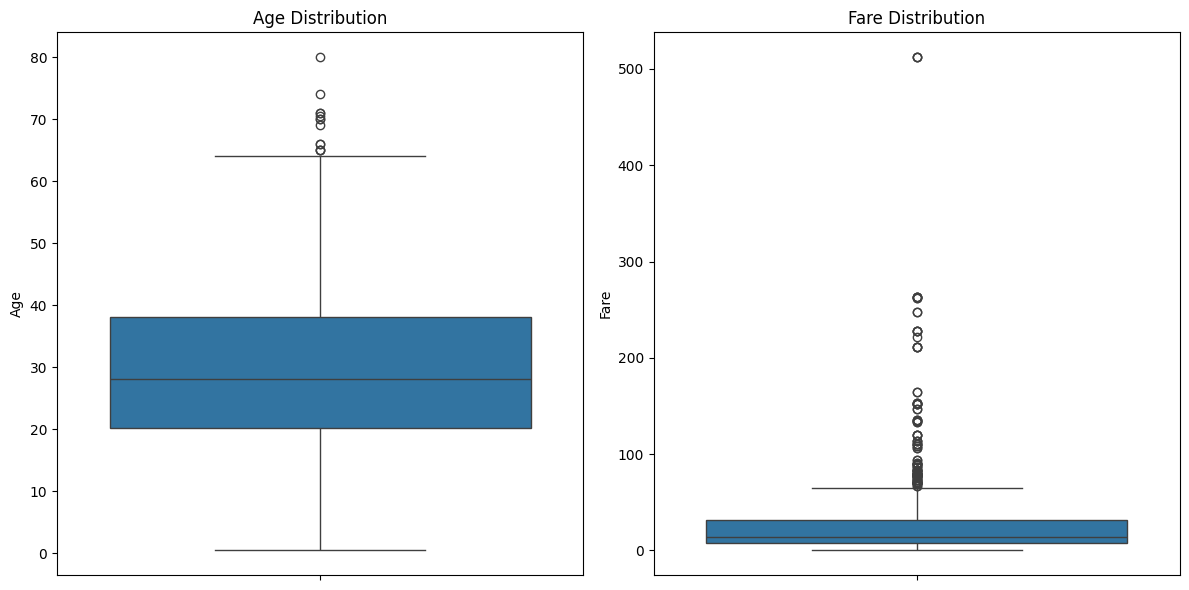

In [38]:
# Visualizing outliers with boxplots

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(y=df0['Age'])
plt.title('Age Distribution')

plt.subplot(1, 2, 2)
sns.boxplot(y=df0['Fare'])
plt.title('Fare Distribution')

plt.tight_layout()
plt.show()

The boxplot above shows that there are outliers in the Age and Fare variable.

It would be helpful to investigate how many rows in the data contain outliers in the Age and Fare column.

In [39]:
# Determine the number of rows containing outliers 

# Compute the 25th percentile value in `Age`
percentile25 = df0['Age'].quantile(0.25)

# Compute the 75th percentile value in `Age`
percentile75 = df0['Age'].quantile(0.75)

# Compute the interquartile range in `Age`
iqr = percentile75 - percentile25

# Define the upper limit for non-outlier values in `Age`
upper_limit = percentile75 + 1.5 * iqr

# Define the lower limit for non-outlier values in `Age`, adjusting for negative values
lower_limit = max(percentile25 - 1.5 * iqr, 0)  # Adjusted lower limit to be at least 0

print("Lower limit:", lower_limit)
print("Upper limit:", upper_limit)

# Identify subset of data containing outliers in `Age`
outliers = df0[(df0['Age'] > upper_limit) | (df0['Age'] < lower_limit)]

# Count how many rows in the data contain outliers in `Age`
print("Number of rows in the data containing outliers in `Age`:", len(outliers))

Lower limit: 0
Upper limit: 64.625
Number of rows in the data containing outliers in `Age`: 13


In [40]:
# Determine the number of rows containing outliers 

# Compute the 25th percentile value in `Fare`
percentile25 = df0['Fare'].quantile(0.25)

# Compute the 75th percentile value in `Fare`
percentile75 = df0['Fare'].quantile(0.75)

# Compute the interquartile range in `Fare`
iqr = percentile75 - percentile25

# Define the upper limit for non-outlier values in `Fare`
upper_limit = percentile75 + 1.5 * iqr

# Define the lower limit for non-outlier values in `Fare`, adjusting for negative values
lower_limit = max(percentile25 - 1.5 * iqr, 0) # Adjusted lower limit to be at least 0

print("Lower limit:", lower_limit)
print("Upper limit:", upper_limit)

# Identify subset of data containing outliers in `Fare`
outliers = df0[(df0['Fare'] > upper_limit) | (df0['Fare'] < lower_limit)]

# Count how many rows in the data contain outliers in `Fare`
print("Number of rows in the data containing outliers in `Fare`:", len(outliers))

Lower limit: 0
Upper limit: 65.95625
Number of rows in the data containing outliers in `Fare`: 116


Step 1 : Data Exploration (Continue EDA)

#### Survival Rate Visualization

The survival count visualization provides a clear picture of the number of passengers who survived versus those who didn't. This is a fundamental aspect of the Titanic dataset, as understanding survival patterns is key to many subsequent analyses. The bar chart will show two bars, each representing survivors and non-survivors, allowing us to quickly grasp the survival rate.


In [30]:
#Begin by understanding how many Passenger survive and what percentage of all Passenger this figure represents.

# Get numbers of people who survive vs. die
print(df0['Survived'].value_counts())
print()

# Get percentages of who survive vs. die
print(df0['Survived'].value_counts(normalize=True))

Survived
0    545
1    342
Name: count, dtype: int64

Survived
0    0.614431
1    0.385569
Name: proportion, dtype: float64


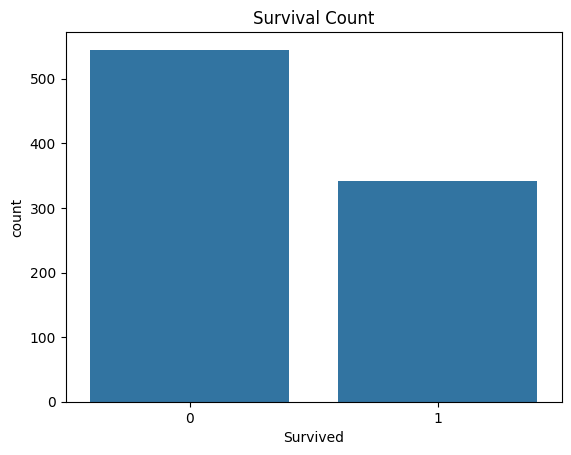

In [41]:
sns.countplot(x='Survived', data=df0)
plt.title('Survival Count')
plt.show()


#### Findings from Survival Rate Visualization

The bar chart likely shows a higher number of non-survivors compared to survivors, reflecting the tragic outcome of the Titanic disaster. This initial observation sets the stage for deeper analyses, exploring factors that might have influenced these survival outcomes.


#### Survival Rate by Passenger Class

Passenger class is a proxy for socio-economic status and might have influenced the survival chances. This visualization compares the survival rates across different classes. A higher survival rate in a higher class could indicate priority in lifeboat allocation or access to better resources for survival.


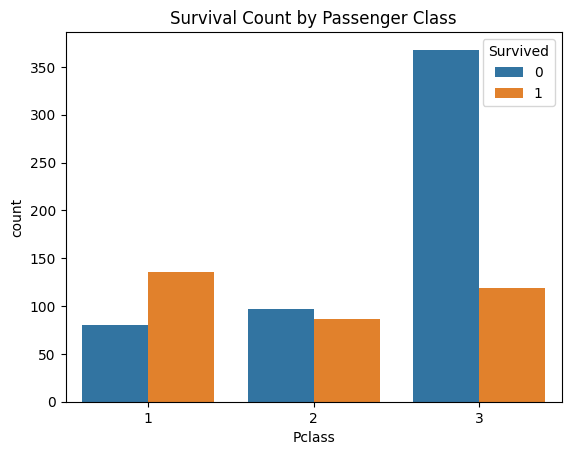

In [42]:
sns.countplot(x='Pclass', hue='Survived', data=df0)
plt.title('Survival Count by Passenger Class')
plt.show()


#### Findings from Survival Rate by Passenger Class

The visualization probably indicates a higher survival rate among first-class passengers compared to second and third classes. This trend suggests socio-economic factors played a role in survival, possibly due to better access to lifeboats or more resources available to higher-class passengers.

#### Survival Rate by Gender

Gender might have played a significant role in survival due to the "women and children first" protocol used for lifeboat boarding. This chart helps us understand the survival distribution between males and females, potentially revealing a bias towards women in survival rates.


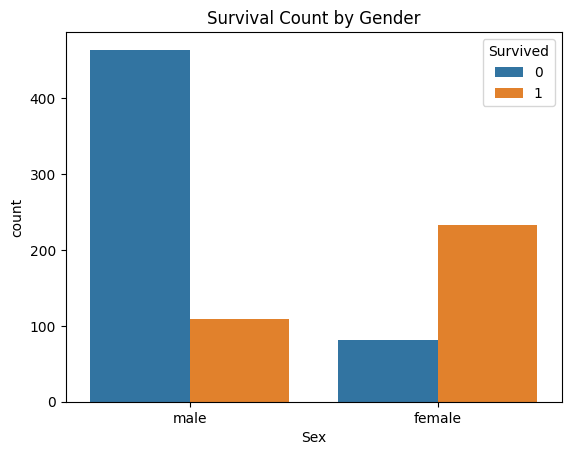

In [46]:
sns.countplot(x='Sex', hue='Survived', data=df0)
plt.title('Survival Count by Gender')
plt.show()


#### Findings from Survival Rate by Gender

The chart is expected to show a significantly higher survival rate for females compared to males, supporting the historical accounts of the "women and children first" protocol. This gender-based difference in survival rates highlights the societal norms and decisions made during the evacuation.


#### Age Histogram

The age distribution of passengers is essential to understand the demographic aboard the Titanic. This histogram provides insights into the age groups present, which can be correlated with survival rates, family sizes, or passenger classes.

#### Age and Survival Boxplot

This boxplot divides the passengers into survivors and non-survivors to compare their age distributions. It helps identify if certain age groups had higher survival rates, which could indicate a preference for saving children, adults, or seniors.


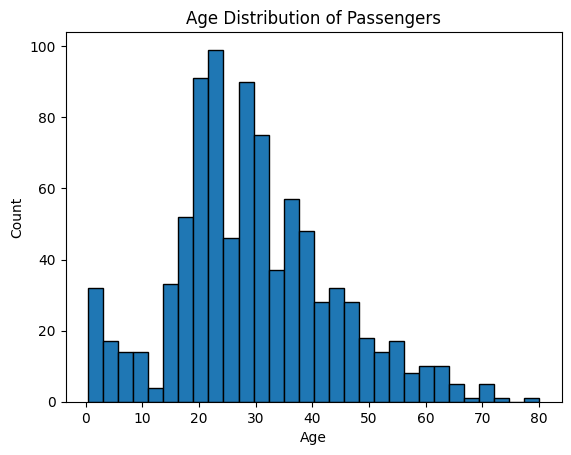

In [43]:
plt.hist(df0['Age'].dropna(), bins=30, edgecolor='black')
plt.title('Age Distribution of Passengers')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


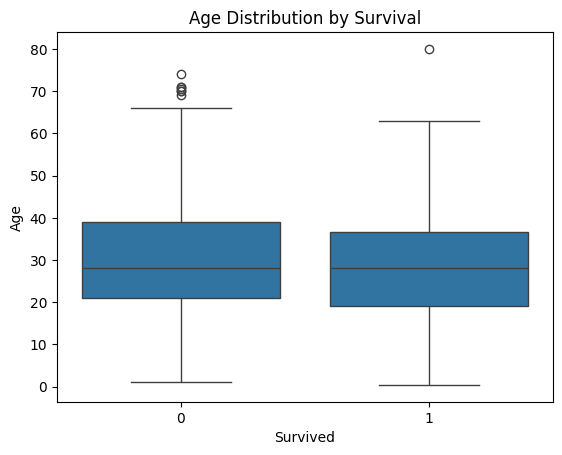

In [44]:
sns.boxplot(x='Survived', y='Age', data=df0)
plt.title('Age Distribution by Survival')
plt.show()


#### Findings from Age Histogram

The age distribution likely shows a wide range of ages with a concentration in younger adults. This demographic snapshot provides context for understanding the life stages of passengers aboard the Titanic.

#### Findings from Age and Survival Boxplot

The boxplot might reveal that younger passengers, particularly children, had higher survival rates. Such a finding would align with prioritization in lifeboat allocation, where children and women were given preference.


#### Fare Histogram

The fare distribution can give us insights into the economic diversity of the Titanic's passengers. It might also correlate with passenger class, embarkation points, or survival, as passengers who paid higher fares might have had better access to lifeboats or been located in parts of the ship that were easier to evacuate from.


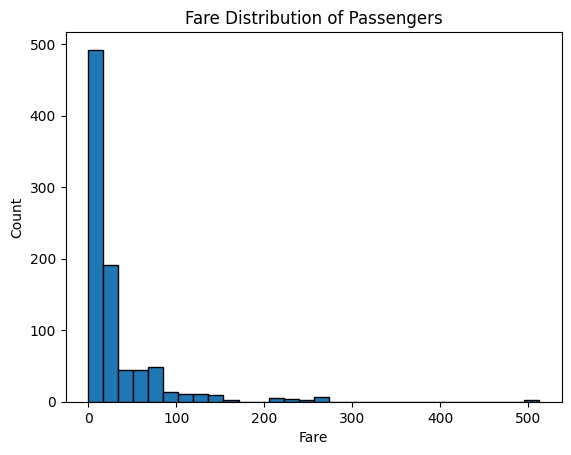

In [47]:
plt.hist(df0['Fare'].dropna(), bins=30, edgecolor='black')
plt.title('Fare Distribution of Passengers')
plt.xlabel('Fare')
plt.ylabel('Count')
plt.show()


#### Findings from Fare Histogram

The fare distribution is expected to be right-skewed, with most passengers paying lower fares and a few paying significantly high fares. This skewness reflects economic disparities and might correlate with survival rates, suggesting passengers who paid more had better chances of survival.


#### Correlation Heatmap

A heatmap of correlations between numerical variables helps identify relationships within the data. For instance, a strong correlation between fare and class might indicate that higher classes indeed paid more, or a correlation between age and survival might reveal age-based survival patterns.


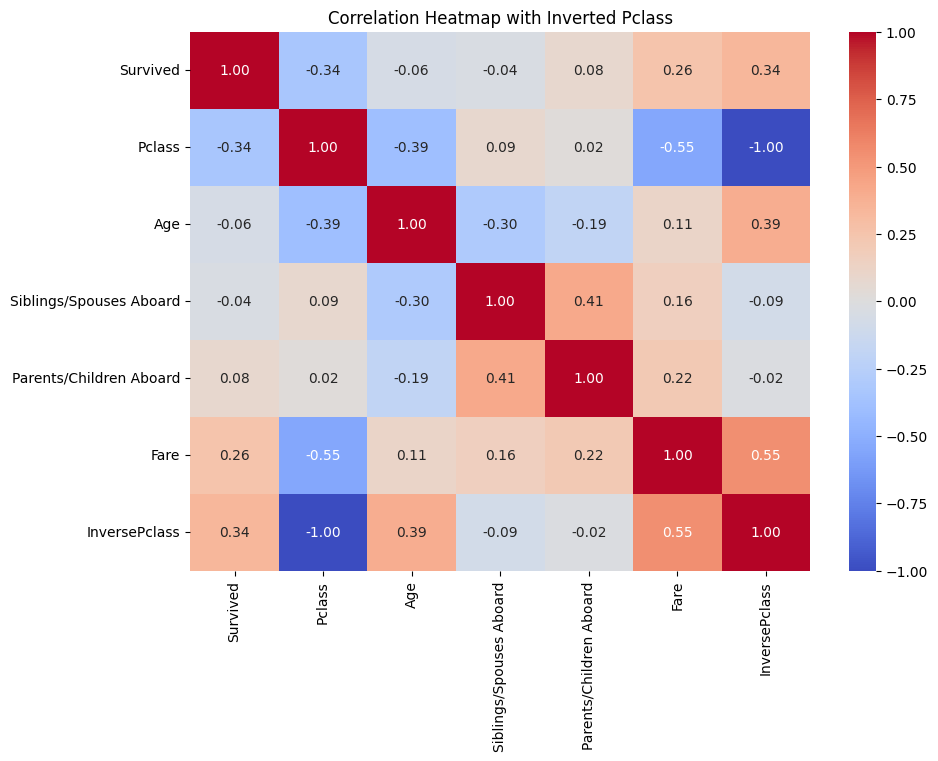

In [51]:
# Create a new column 'InversePclass' where the class values are inverted
df0['InversePclass'] = df0['Pclass'].apply(lambda x: 4 - x)

# Select only numeric columns for the correlation calculation, including the new 'InversePclass'
numeric_df = df0.select_dtypes(include=[np.number])

# Calculate the correlation and create a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap with Inverted Pclass')
plt.show()

#### Findings from Correlation Heatmap with Inverted Pclass

The heatmap now includes `InversePclass`, an inverted representation of the original `Pclass`, where higher values indicate higher passenger classes (First Class is the highest). This adjustment leads to the following insights:

- **Positive Correlation between `Fare` and `InversePclass`**: As expected, there is a positive correlation between `Fare` and `InversePclass`. This indicates that passengers in higher classes (First Class, now represented by higher `InversePclass` values) tend to pay higher fares. This positive correlation aligns more intuitively with the understanding that better accommodations (higher classes) come at higher costs.

- **Correlation between `InversePclass` and Survival**: The correlation between `InversePclass` and `Survived` can be observed to understand if passengers in higher classes had better survival rates. A positive correlation would suggest that higher-class passengers (now represented by higher `InversePclass` values) had higher survival rates, possibly due to better access to lifeboats or more resources available for survival.

- **Other Correlations**: The heatmap continues to show correlations between other numeric variables, such as age and siblings/spouses aboard, parents/children aboard, etc. Each correlation coefficient gives insight into the linear relationship between pairs of variables, where values closer to 1 or -1 indicate strong positive or negative correlations, respectively, and values near 0 indicate a weak or no linear relationship.

The introduction of `InversePclass` helps in making the correlation between class and fare more intuitive and highlights the socioeconomic factors influencing fare and potentially survival rates. When interpreting the heatmap, it's important to consider the nature of each variable and the context of the Titanic dataset to draw meaningful conclusions.


#### Siblings/Spouses Aboard Histogram

This histogram shows the distribution of passengers traveling with siblings or spouses. It's interesting to explore how family size or traveling with a partner affected survival chances, as those with family onboard might have had different priorities during evacuation.


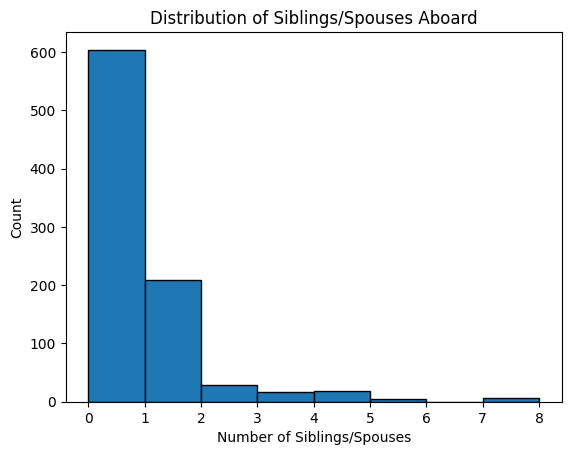

In [53]:
plt.hist(df0['Siblings/Spouses Aboard'].dropna(), bins=range(0, df0['Siblings/Spouses Aboard'].max() + 1), edgecolor='black')
plt.title('Distribution of Siblings/Spouses Aboard')
plt.xlabel('Number of Siblings/Spouses')
plt.ylabel('Count')
plt.show()


#### Findings from Siblings/Spouses Aboard Histogram

The histogram likely shows that most passengers traveled without siblings or spouses, while a smaller number traveled with one or more. This distribution helps us understand social structures aboard and could indicate that those traveling with spouses or siblings had different survival dynamics.


#### Parents/Children Aboard Histogram

Similar to the analysis of siblings/spouses, this histogram provides insight into passengers traveling with parents or children. It helps us understand family dynamics aboard the Titanic and whether having children influenced survival chances due to the potential prioritization of families in evacuation efforts.


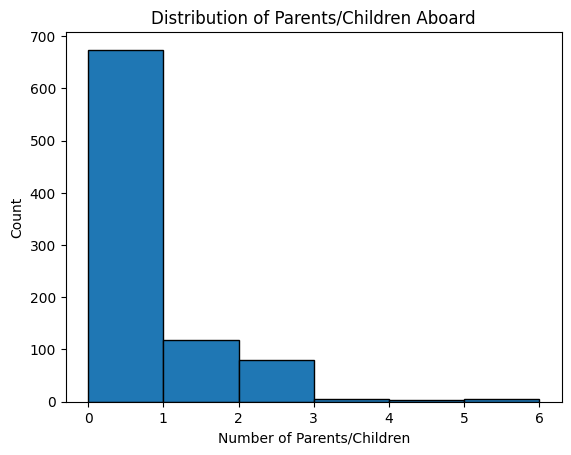

In [54]:
plt.hist(df0['Parents/Children Aboard'].dropna(), bins=range(0, df0['Parents/Children Aboard'].max() + 1), edgecolor='black')
plt.title('Distribution of Parents/Children Aboard')
plt.xlabel('Number of Parents/Children')
plt.ylabel('Count')
plt.show()


#### Findings from Parents/Children Aboard Histogram

Similar to the siblings/spouses analysis, this histogram probably shows a significant number of passengers traveled without parents or children, while families aboard had varying sizes. The presence of children might have influenced survival rates due to the potential prioritization of families during evacuation.

